<a href="https://colab.research.google.com/github/diazpuem/crescendo/blob/main/DataCleaningForNetflixDataSet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import csv
import os





# Data Preprocessing
First of all we want to transform the movieId into a column so we could have something like and then put each file into a csv .
`MovieId,CustomerID,Rating,Date` instead of having the movieId in one line separated. In order to do that we will use Regular Expressions to identify the movieId lines and the rating Lines.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

def preprocessTrainingSetToCsv(inputFiles):
    movieIdPattern = r'^(\d+):\s*$'
    ratingsPattern = r'^(\d+),\s*([\d.]+),\s*(\d{4}-\d{2}-\d{2})$'
    csvHeader = ['MovieId', 'CustId', 'Rating', 'Date']
    outputPrefix = 'drive/MyDrive/NetflixDataSet/combined_data_'
    fileIndex = 1
    for inputFile in inputFiles:
      outputFileName = outputPrefix + str(fileIndex) + ".csv"
      with open(outputFileName, 'w', newline='') as writable:
        writer = csv.writer(writable)
        writer.writerow(csvHeader)
        outputData = []
        movieId = None
        print(inputFile)
        with open(inputFile, 'r') as file:
          for row in file:
            row = row.strip()
            movieIdMatch = re.match(movieIdPattern, row)
            ratingsMatch = re.match(ratingsPattern, row)
            if movieIdMatch:
              movieId = movieIdMatch.group(1)
            elif ratingsMatch:
              custId = ratingsMatch.group(1)
              rating = ratingsMatch.group(2)
              date = ratingsMatch.group(3)
              outputData.append([movieId, custId, rating, date])
            else:
              raise Exception('Not pattern found')
        writer.writerows(outputData)
      print("File:", outputFileName, "Created Succesfully")
      fileIndex = fileIndex + 1

    print("Process Finished")


Mounted at /content/drive


Lets use the function

In [ ]:
inputFiles = [
    'drive/MyDrive/NetflixDataSet/combined_data_1.txt',
    'drive/MyDrive/NetflixDataSet/combined_data_2.txt',
    'drive/MyDrive/NetflixDataSet/combined_data_3.txt',
    'drive/MyDrive/NetflixDataSet/combined_data_4.txt'
]
preprocessTrainingSetToCsv(inputFiles)

drive/MyDrive/NetflixDataSet/combined_data_1.txt
File: drive/MyDrive/NetflixDataSet/combined_data_1.csv Created Succesfully
drive/MyDrive/NetflixDataSet/combined_data_2.txt
File: drive/MyDrive/NetflixDataSet/combined_data_2.csv Created Succesfully
drive/MyDrive/NetflixDataSet/combined_data_3.txt
File: drive/MyDrive/NetflixDataSet/combined_data_3.csv Created Succesfully
drive/MyDrive/NetflixDataSet/combined_data_4.txt
File: drive/MyDrive/NetflixDataSet/combined_data_4.csv Created Succesfully
Process Finished


Also we noticed that for the movie titles in the movie_titles.csv there are some movies that have its title split up among more than one column so we need to make sure that when we read the CSV it handles this bad lines and take the rest of the columns as one. So we are going to create a function to handle this

In [ ]:
def handleTitles(line):
  fields = [str(field) for field in line]
  movieId = int(fields[0])
  releaseYear = int(fields[1])
  combinedTitle = ''.join(fields[2:]).strip()
  return movieId, releaseYear, combinedTitle


movieTitlesData = pd.read_csv('drive/MyDrive/NetflixDataSet/movie_titles.csv',
                              header = 0,
                              encoding = 'ISO-8859-1',
                              engine = 'python',
                              on_bad_lines= handleTitles)

movieTitlesData.head()

,1,2003,Dinosaur Planet
0,2,2004.0,Isle of Man TT 2004 Review
1,3,1997.0,Character
2,4,1994.0,Paula Abdul's Get Up & Dance
3,5,2004.0,The Rise and Fall of ECW
4,6,1997.0,Sick


Now Lets move it to a CSV

In [ ]:
file = 'drive/MyDrive/NetflixDataSet/movieTitlesPreprocessed.csv'
movieTitlesData.to_csv(file, index=False)
print('Movie Titles Preprocessed file created')

Movie Titles Preprocessed file created


# Data Cleaning

Lets check missing values and duplicates in the training set.

In [ ]:
trainingDataSet = pd.read_csv('drive/MyDrive/NetflixDataSet/combined_data_1.csv', engine = 'python')
trainingDataSet.head()



,MovieId,CustId,Rating,Date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03


Checking for duplicated rows or Null Values

In [ ]:
duplicatedRows = trainingDataSet.duplicated().sum()
nullRowsPerColumn = trainingDataSet.isnull().sum()
print("Duplicated rows", duplicatedRows)
print("Any Null Values")
print(nullRowsPerColumn)

Duplicated rows 0
Any Null Values
MovieId    0
CustId     0
Rating     0
Date       0
dtype: int64


Dropping rows if found. We decided not to use any imputer since any row with a null value is not valuable for our dataset since each column is important for the training.

In [ ]:
if duplicatedRows > 0:
  print("Cleaning duplicates current rows:", len(trainingDataSet.index))
  trainingDataSet.drop_duplicates()
  print("Data set after cleaning rows:", len(trainingDataSet.index))

for index, value in nullRowsPerColumn.items():
  if value > 0:
    print("Cleaning null values current rows:", len(trainingDataSet.index))
    trainingDataSet.dropna(subset=[index], inplace=True)
    print("Data set after cleaning rows:", len(trainingDataSet.index))

# Data Visualization

After the cleaning we would like to see how are the ratings distributed over the users and also check how are the ratings distributed for a random movie over the time.

In [ ]:
import matplotlib.pyplot as plt
groupedByRatings = trainingDataSet.groupby('Rating')['Rating'].agg(['count'])
print(groupedByRatings)


          count
Rating         
1       1118186
2       2439073
3       6904181
4       8085741
5       5506583


Lets visualize by ratings

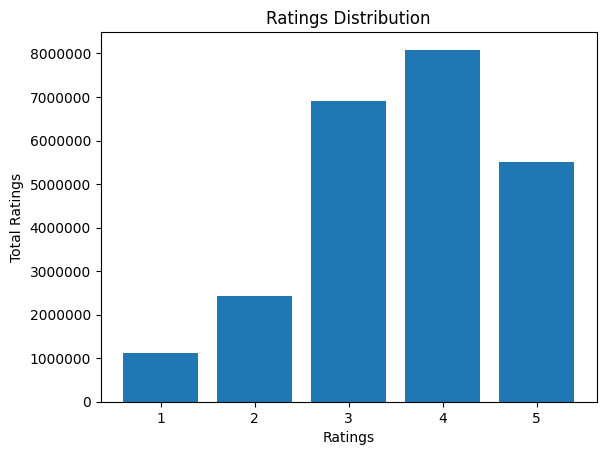

In [ ]:
fig, ax = plt.subplots()
ax.bar([1,2,3,4,5], groupedByRatings['count'])
ax.ticklabel_format(style='plain')
plt.xlabel("Ratings")
plt.ylabel("Total Ratings")
plt.title("Ratings Distribution")
plt.show()

In order to look for a good classifier we will use a new library called scikit-surprise which is very focused on Recommendation Systems, it also comes with a cross_validate function and the SVD algorithm which could be a good fit for our problem.

In [ ]:
# Import required libraries
!pip install scikit-surprise
from surprise import Reader, Dataset, SVD, SVDpp, NMF
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import KFold
from surprise import accuracy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163752 sha256=824e8d0ab81e2b2575347cd4d8a9db6eccab9bf0aec3986e458e67197bbab1cd
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


The Surprise library comes with a reader and integrates with pandas dataframes so we can easily convert the dataset between libraries.

In [ ]:
reader = Reader()
# For processing time, we will use rows. Also we won't consider the Date Column.
subSetTrainingDataSet = trainingDataSet[['CustId', 'MovieId', 'Rating']][:2000000]

In [ ]:
convertedDataSet = Dataset.load_from_df(subSetTrainingDataSet, reader)

Lets cross validate using the SVD with 7 splits or folds and number of epochs in 50.
As measures we will use RMSE (Root-mean-square Error) and MAE (Mean absolute error).

In [ ]:
kf = KFold(n_splits=7)
svd = SVD(n_epochs = 50)

# Compute the RMSE of the SVD algorithm
cross_validate(svd, convertedDataSet, measures=['RMSE', 'MAE'], cv=kf, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 7 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Mean    Std     
RMSE (testset)    1.0007  0.9991  0.9996  0.9989  0.9988  1.0029  0.9969  0.9996  0.0017  
MAE (testset)     0.7859  0.7850  0.7860  0.7846  0.7842  0.7875  0.7827  0.7851  0.0014  
Fit time          104.26  114.70  110.89  109.68  108.86  109.72  111.76  109.98  2.94    
Test time         2.19    2.31    3.41    2.19    3.36    2.22    3.48    2.74    0.59    


{'test_rmse': array([1.00074362, 0.99910809, 0.99964731, 0.99892939, 0.99878595,
        1.00289861, 0.99686149]),
 'test_mae': array([0.7858769 , 0.7849709 , 0.78602722, 0.78462041, 0.78421464,
        0.78747266, 0.78270802]),
 'fit_time': (104.25899338722229,
  114.699551820755,
  110.89485454559326,
  109.6760082244873,
  108.85636186599731,
  109.71540093421936,
  111.75787878036499),
 'test_time': (2.186509609222412,
  2.313668727874756,
  3.414968252182007,
  2.1863462924957275,
  3.3637986183166504,
  2.219083786010742,
  3.4808878898620605)}

Now lets check another classifier called SVD++ which is an extension of SVD taking into account implicit ratings.

In [ ]:
svdpp = SVDpp(n_epochs=50)
cross_validate(svdpp, convertedDataSet, measures=['RMSE', 'MAE'], cv=kf, verbose=True)

Evaluating RMSE, MAE of algorithm SVDpp on 7 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Mean    Std     
RMSE (testset)    1.0292  1.0262  1.0283  1.0300  1.0326  1.0265  1.0282  1.0287  0.0020  
MAE (testset)     0.8038  0.8008  0.8029  0.8030  0.8057  0.8017  0.8022  0.8029  0.0015  
Fit time          180.17  183.18  179.75  181.98  181.51  183.21  180.67  181.49  1.28    
Test time         14.77   14.24   12.16   11.79   14.17   13.51   11.36   13.14   1.25    


{'test_rmse': array([1.02922761, 1.02621488, 1.02833378, 1.02998459, 1.03255167,
        1.02646391, 1.02816716]),
 'test_mae': array([0.8038432 , 0.80083173, 0.80285081, 0.80302919, 0.80570592,
        0.80173674, 0.80224873]),
 'fit_time': (180.1685004234314,
  183.1796305179596,
  179.7461760044098,
  181.9803650379181,
  181.50749850273132,
  183.2081618309021,
  180.6730761528015),
 'test_time': (14.771211862564087,
  14.237662553787231,
  12.1637864112854,
  11.785116910934448,
  14.16684865951538,
  13.508783102035522,
  11.35804033279419)}

Now lets try with another classifier called NMF (Non-negative matrix factorization).

In [ ]:
nmf = NMF(n_epochs=50)
cross_validate(nmf, convertedDataSet, measures=['RMSE', 'MAE'], cv=kf, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 7 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Mean    Std     
RMSE (testset)    1.0908  1.1018  1.0918  1.0911  1.0925  1.0931  1.0962  1.0939  0.0036  
MAE (testset)     0.8543  0.8656  0.8545  0.8552  0.8558  0.8583  0.8613  0.8579  0.0039  
Fit time          98.63   97.88   98.81   98.68   99.22   97.71   99.74   98.67   0.65    
Test time         4.96    5.11    5.18    5.50    2.96    5.74    5.67    5.02    0.88    


{'test_rmse': array([1.0907914 , 1.10178885, 1.09178476, 1.09113835, 1.09248041,
        1.0931442 , 1.09617776]),
 'test_mae': array([0.85428073, 0.86560639, 0.85454089, 0.85521321, 0.85584362,
        0.85828404, 0.8613063 ]),
 'fit_time': (98.625164270401,
  97.88445925712585,
  98.80703353881836,
  98.67729496955872,
  99.21545076370239,
  97.71130418777466,
  99.73813509941101),
 'test_time': (4.958001136779785,
  5.105950593948364,
  5.1753644943237305,
  5.496279239654541,
  2.9595775604248047,
  5.743624448776245,
  5.667731285095215)}

As the cross validations results we could conclude the SVD algorithm is the best fit for this recommendation system. We proceed to train our algorithm.

# Data Training

In [ ]:

# Splitting the dataset
trainSet, testSet = train_test_split(convertedDataSet, test_size=.25)

# Training Classifier
svd.fit(trainSet)

# Testing Classifier
predictions = svd.test(testSet)

# Measure the accuracy
accuracy.rmse(predictions)
accuracy.mae(predictions)



RMSE: 1.0028
MAE:  0.7886


0.7886056113090073

In [ ]:
# Reading the movie titles
moviesTitles = pd.read_csv('drive/MyDrive/NetflixDataSet/movieTitlesPreprocessed.csv',
                           engine = 'python',
                           names =['MovieId', 'ReleaseYear', 'MovieTitle'],
                           encoding = 'ISO-8859-1'
                          )
moviesTitles.head()

,MovieId,ReleaseYear,MovieTitle
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


Using a random user to test the predictions

In [ ]:
user7 = trainingDataSet[(trainingDataSet['CustId'] == 7) & (trainingDataSet['Rating'] == 5)]
user7.head()

,MovieId,CustId,Rating,Date
12541,8,7,5,2005-07-30
151587,30,7,5,2004-09-27
323022,83,7,5,2005-10-30
622053,175,7,5,2004-09-09
1134703,257,7,5,2005-05-23


In [ ]:
user7Estimates = moviesTitles.copy()
user7Estimates['EstimateRating'] = user7Estimates['MovieId'].apply(lambda movieId: svd.predict(7, movieId).est)


In [ ]:
user7Estimates = user7Estimates.sort_values('EstimateRating', ascending=False)
user7Estimates.head()

,MovieId,ReleaseYear,MovieTitle,EstimateRating
12,13,2003.0,Lord of the Rings: The Return of the King: Ext...,5.0
289,290,2004.0,Harold and Kumar Go to White Castle,5.0
208,209,1996.0,Star Trek: Deep Space Nine: Season 5,5.0
4,5,2004.0,The Rise and Fall of ECW,5.0
67,68,2004.0,Invader Zim,5.0


Now that we tested the system for a specific user we could create a function for predictions from any user.

In [ ]:
def predictMovies(userId):
    userId = int(userId)
    userEstimates = moviesTitles.copy()
    userEstimates = userEstimates.reset_index()
    #Predict the ratings
    userEstimates['EstimatedRating'] = userEstimates['MovieId'].apply(lambda x: svd.predict(userId, x).est)
    #Drop extra columns from the user data frame
    userEstimates = userEstimates.drop('MovieId', axis = 1)
    # Sort predicted ratings in descending order
    userEstimates = userEstimates.sort_values('EstimatedRating', ascending=False)
    #Print top 10 recommendations
    print(userEstimates.head(10))

Now we can predict top 10 movies from any user

In [ ]:
predictMovies(885013)

     index  ReleaseYear                                         MovieTitle  \
75      75       1952.0                              I Love Lucy: Season 2   
151    151       1995.0                                  A Little Princess   
12      12       2003.0  Lord of the Rings: The Return of the King: Ext...   
344    344       1998.0                       Star Trek: Voyager: Season 5   
315    315       1999.0      Futurama: Monster Robot Maniac Fun Collection   
84      84       2005.0                                         Elfen Lied   
208    208       1996.0               Star Trek: Deep Space Nine: Season 5   
303    303       1997.0                         King of the Hill: Season 1   
4        4       2004.0                           The Rise and Fall of ECW   
137    137       1995.0                       Star Trek: Voyager: Season 1   

     EstimatedRating  
75          4.923346  
151         4.899448  
12          4.834126  
344         4.821475  
315         4.818583  
84 